# Л.р. №5: Непараметрическая регрессия

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator
from sklearn.cross_validation import train_test_split, cross_val_score
from numpy.linalg import norm

## Часть 1. Обработка и визуализация данных

In [3]:
data = pd.read_csv("non-parametric.csv", sep=";", index_col="id")

In [4]:
X = data["x"].values
y = data["y"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

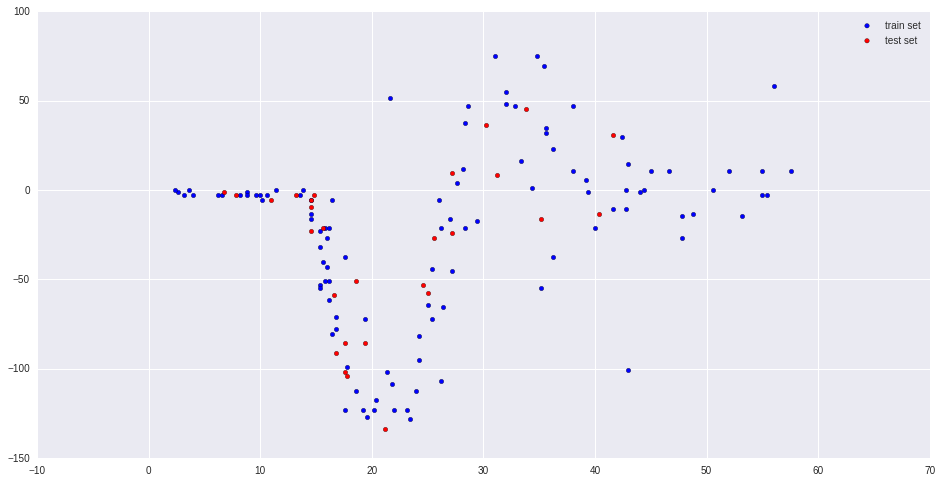

In [6]:
plt.figure(figsize=(16, 8))
plt.scatter(X_train, y_train, c="b", label="train set")
plt.scatter(X_test, y_test, c="r", label="test set")
plt.legend(loc=1)
plt.show()

## Часть 2. Формула ядерного сглаживания Надарая-Ватсона

In [7]:
euclidean_metric = lambda x, y: np.sqrt(np.dot(x - y, x - y))

In [8]:
rectangular_kernel = lambda x: 1             if abs(x) <= 1 else 0
triangular_kernel  = lambda x: 1 - abs(x)    if abs(x) <= 1 else 0
quartic_kernel     = lambda x: (1 - x**2)**2 if abs(x) <= 1 else 0
gaussian_kernel    = lambda x: np.exp(-2*(x**2))

In [9]:
class NadarayaWatsonRegression(BaseEstimator):
    def __init__(self, kernel_func, h, metric=euclidean_metric):
        self.kernel_func = kernel_func
        self.h = h
        self.metric = metric

    def get_params(self, deep=False):
        return {"kernel_func": self.kernel_func,
                "h": self.h,
                "metric": self.metric}

    def set_params(self, **params):
        self.kernel_func = params["kernel_func"]
        self.h = params["h"]
        self.metric = params["metric"]

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        ys = []
        for x in X:
            n = 0 
            d = 0
            for xi, yi in zip(self.X, self.y):
                k = self.kernel_func(self.metric(x, xi) / self.h)
                n += yi * k
                d += k
            ys.append(n / d)
        return np.array(ys)

In [10]:
def plot_nadaraya_watson(kernel, hs, title):
    x_curve = np.arange(0, 60, 0.1)
    ys_curve = []
    mses = {"train": [], "test": []}
    for h in hs:
        nw = NadarayaWatsonRegression(kernel, h)
        nw.fit(X_train, y_train)
        y_curve = nw.predict(x_curve)
        ys_curve.append(y_curve)
        for xs, ys, err_type in zip([X_train, X_test], [y_train, y_test], ["train", "test"]):
            y_pred = nw.predict(xs)
            err = euclidean_metric(ys, y_pred) / len(ys)
            print("h=%.2f: mse_%s=%.2f" % (h, err_type, err))

    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.scatter(X_train, y_train, c="b", label="train set")
    plt.scatter(X_test, y_test, c="r", label="test set")
    for h, y_curve in zip(hs, ys_curve):
        plt.plot(x_curve, y_curve, label="h = %.2f" % h)
    plt.legend(loc=1)
    plt.show()

h=0.25: mse_train=2.23
h=0.25: mse_test=nan
h=1.00: mse_train=2.52
h=1.00: mse_test=4.59
h=3.00: mse_train=2.97
h=3.00: mse_test=4.65


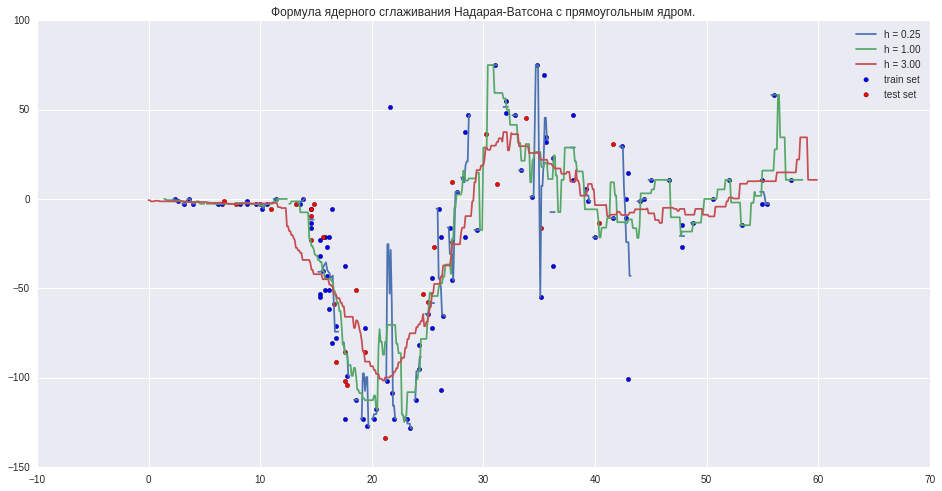

In [11]:
plot_nadaraya_watson(rectangular_kernel, [0.25, 1.0, 3.0], "Формула ядерного сглаживания Надарая-Ватсона с прямоугольным ядром.")

- Кусочно-постоянная аппроксимация
- Не определена, если в области [$x$; $x+h$] нету точек выборки

h=0.25: mse_train=1.59
h=0.25: mse_test=nan
h=1.00: mse_train=2.32
h=1.00: mse_test=5.27
h=3.00: mse_train=2.72
h=3.00: mse_test=4.76


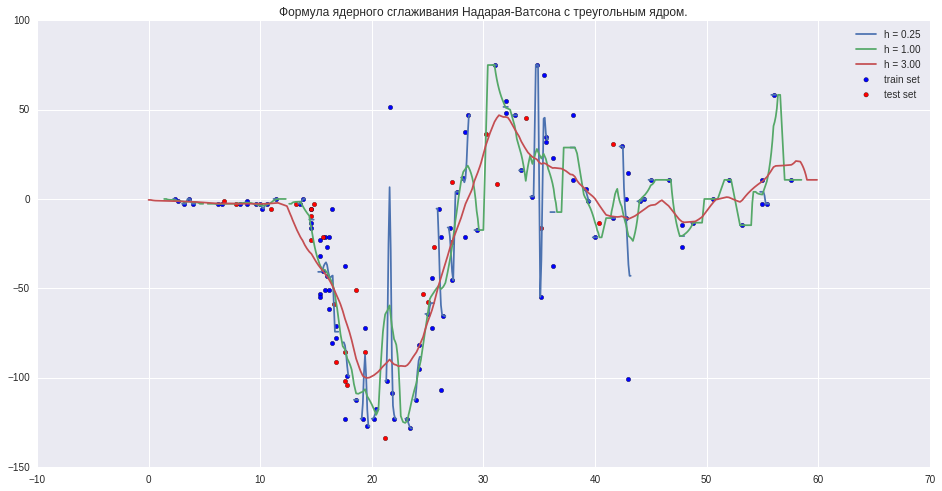

In [12]:
plot_nadaraya_watson(triangular_kernel, [0.25, 1.0, 3.0], "Формула ядерного сглаживания Надарая-Ватсона с треугольным ядром.")

- Кусочно-линейная аппроксимация

h=0.25: mse_train=1.67
h=0.25: mse_test=4.81
h=1.00: mse_train=2.40
h=1.00: mse_test=5.12
h=3.00: mse_train=2.80
h=3.00: mse_test=4.73


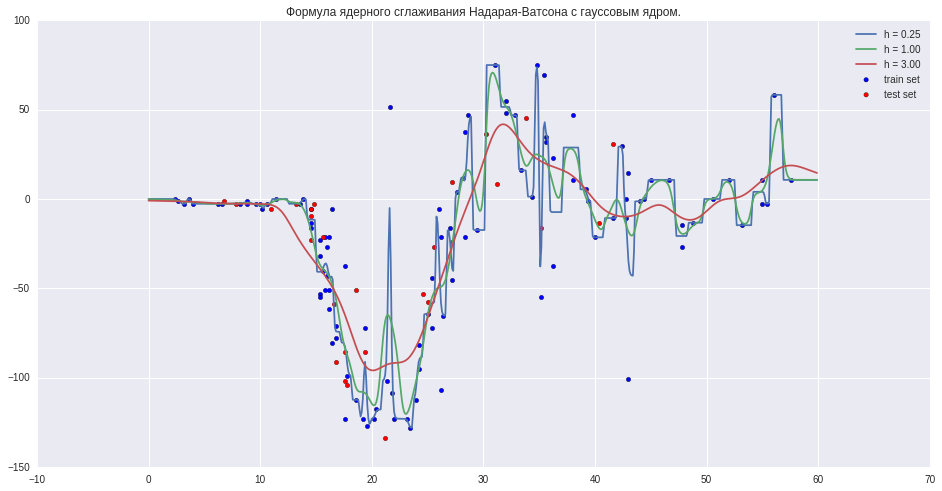

In [13]:
plot_nadaraya_watson(gaussian_kernel, [0.25, 1.0, 3.0], "Формула ядерного сглаживания Надарая-Ватсона с гауссовым ядром.")

- Гладкая аппроксимация

**Выводы**:
* Качество классификации сильно зависит от ширины окна $h$
* Выбор ядра, напротив, слабо влияет на качество классификации, но влияет на гладкость $a_h(x)$

## Часть 3. Робастная непараметрическая регрессия. Алгоритм LOWESS

In [14]:
class LOWESSRegression(BaseEstimator):
    def __init__(self, kernel_func, k, metric=euclidean_metric):
        self.kernel_func = kernel_func
        self.k = k
        self.metric = metric

    def get_params(self, deep=False):
        return {"kernel_func": self.kernel_func,
                "k": self.k,
                "metric": self.metric}

    def set_params(self, **params):
        self.kernel_func = params["kernel_func"]
        self.k = params["k"]
        self.metric = params["metric"]

    def _loo(self, i, gammas):
        n = 0
        d = 0
        xi = self.X[i]
        hi = self.hs[i]

        for j, (xj, yj, γj) in enumerate(zip(self.X, self.y, gammas)):
            if i == j: continue
            k = self.kernel_func(self.metric(xi, xj) / hi)
            n += yj * γj * k
            d += γj * k
        return n / d

    def fit(self, X, y):
        self.X = X
        self.y = y
        N = len(self.X)
        gammas = [1.] * N

        # precalculate h_i
        self.hs = []
        for i in range(N):
            xi = self.X[i]
            dists = list(map(lambda y: self.metric(xi, y), self.X))
            hi = np.partition(dists, self.k, axis=0)[self.k]
            self.hs.append(hi)

        for t in range(50):
            answers = []
            errs = []
            for i in range(N):
                answers.append(self._loo(i, gammas))
            for i in range(N):
                errs.append(abs(answers[i] - self.y[i]))
            err_median = np.median(errs)
            mean_change = 0
            for i in range(N):
                # soft filtration kernel
                newval = quartic_kernel(errs[i] / (6 * err_median))
                mean_change += abs(newval - gammas[i])
                gammas[i] = newval
            if mean_change / N <= 1e-6:
                break
            
        self.gammas = np.array(gammas)

    def predict(self, X):
        ys = []
        for x in X:
            n = 0
            d = 0
            for xi, yi, γi, hi in zip(self.X, self.y, self.gammas, self.hs):
                k = self.kernel_func(self.metric(x, xi) / hi)
                n += yi * γi * k
                d += γi * k
            ys.append(n / d)
        return np.array(ys)

In [15]:
def plot_lowess(kernel, ks, title):
    x_curve = np.arange(0, 60, 0.1)
    ys_curve = []
    mses = {"train": [], "test": []}
    for k in ks:
        nw = LOWESSRegression(kernel, k)
        nw.fit(X_train, y_train)
        y_curve = nw.predict(x_curve)
        ys_curve.append(y_curve)
        for xs, ys, err_type in zip([X_train, X_test], [y_train, y_test], ["train", "test"]):
            y_pred = nw.predict(xs)
            err = euclidean_metric(ys, y_pred) / len(ys)
            print("k=%d: mse_%s=%.2f" % (k, err_type, err))

    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.scatter(X_train, y_train, c="b", label="train set")
    plt.scatter(X_test, y_test, c="r", label="test set")
    for k, y_curve in zip(ks, ys_curve):
        plt.plot(x_curve, y_curve, label="k = %d" % k)
    plt.legend(loc=1)
    plt.show()

k=5: mse_train=2.83
k=5: mse_test=4.35
k=10: mse_train=2.84
k=10: mse_test=4.07
k=15: mse_train=2.82
k=15: mse_test=3.88


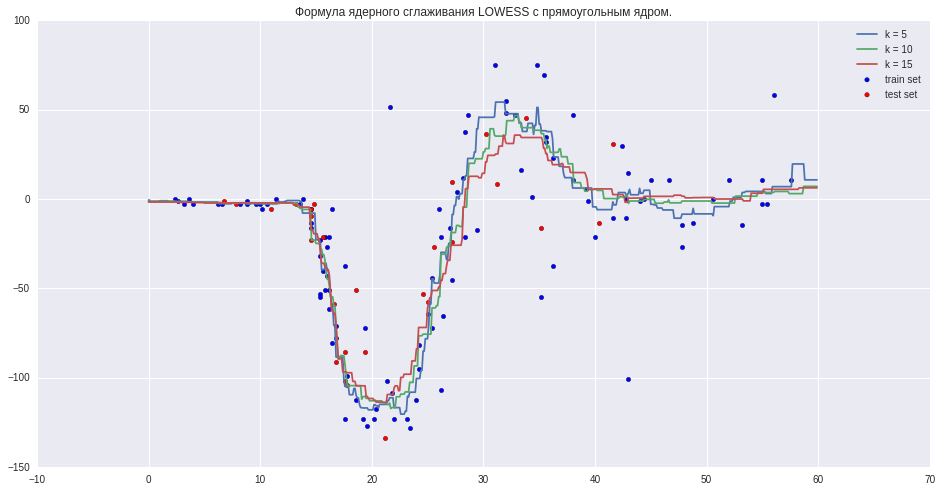

In [16]:
plot_lowess(rectangular_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с прямоугольным ядром.")

k=5: mse_train=2.76
k=5: mse_test=4.94
k=10: mse_train=2.79
k=10: mse_test=4.27
k=15: mse_train=2.81
k=15: mse_test=4.06


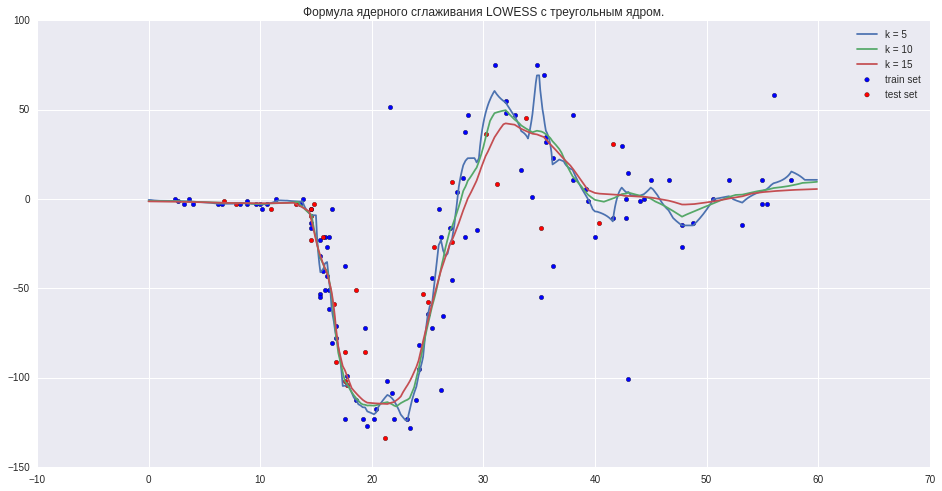

In [17]:
plot_lowess(triangular_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с треугольным ядром.")

k=5: mse_train=2.76
k=5: mse_test=4.65
k=10: mse_train=2.78
k=10: mse_test=4.14
k=15: mse_train=2.80
k=15: mse_test=3.94


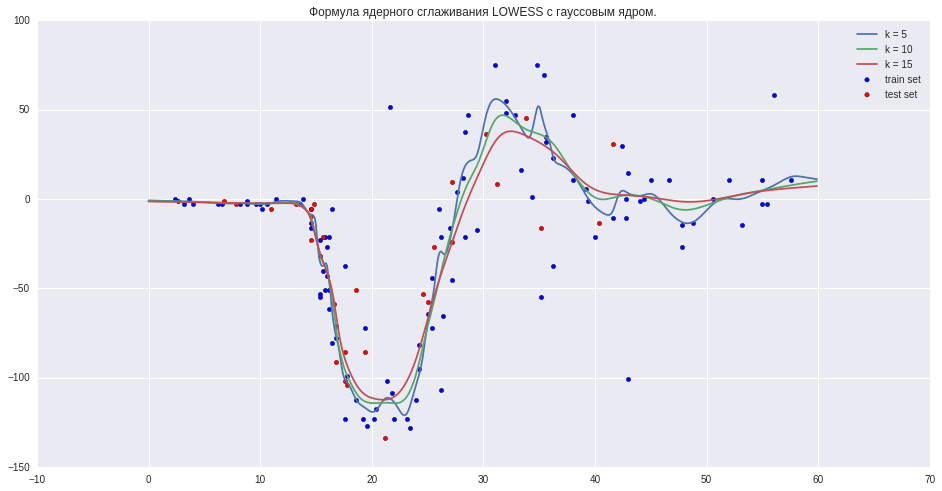

In [18]:
plot_lowess(gaussian_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с гауссовым ядром.")

## Часть 4. Проверка робастности

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
for x_dropout in np.arange(0, 60, 3):
    eps = 0.1
    X_train = np.append(X_train, [x_dropout - eps, x_dropout + eps])
    y_train = np.append(y_train, [-500, 500])

h=0.25: mse_train=12.40
h=0.25: mse_test=23.83
h=1.00: mse_train=21.07
h=1.00: mse_test=6.41
h=3.00: mse_train=21.51
h=3.00: mse_test=4.90


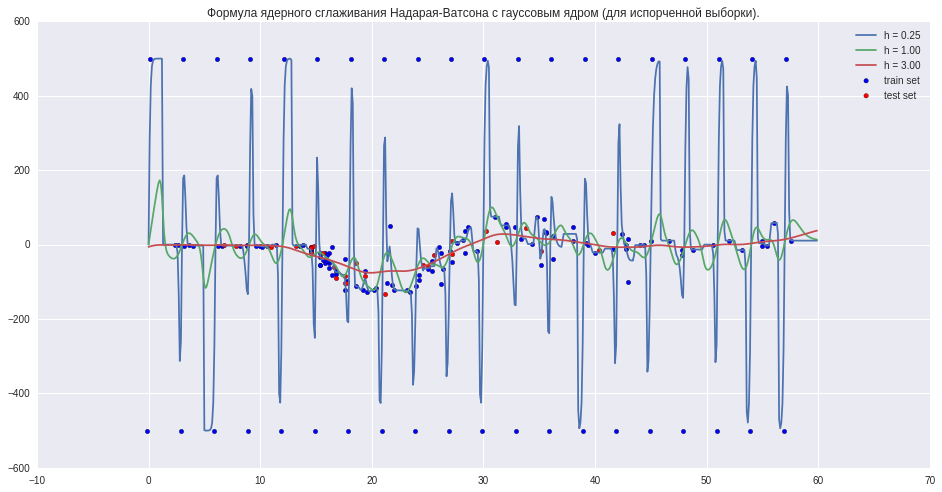

In [21]:
plot_nadaraya_watson(gaussian_kernel, [0.25, 1.0, 3.0], "Формула ядерного сглаживания Надарая-Ватсона с гауссовым ядром (для испорченной выборки).")

k=5: mse_train=21.52
k=5: mse_test=4.73
k=10: mse_train=21.54
k=10: mse_test=4.18
k=15: mse_train=21.54
k=15: mse_test=4.04


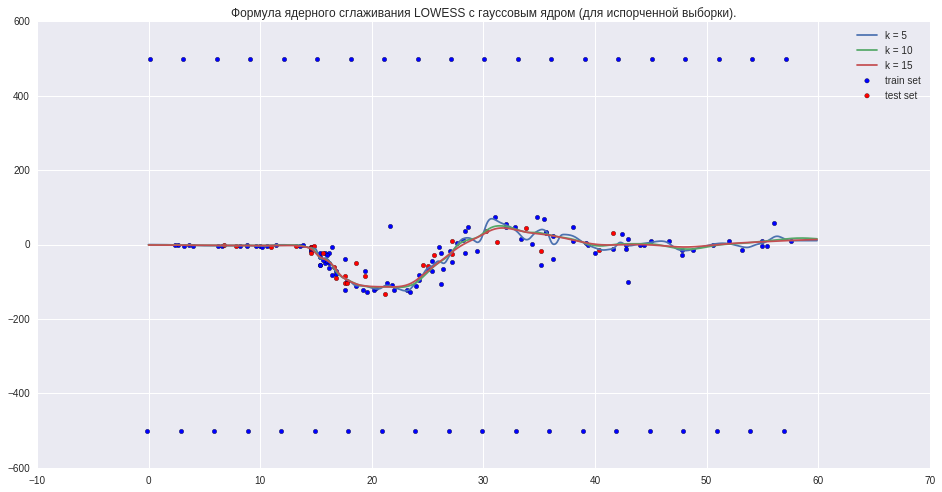

In [22]:
plot_lowess(gaussian_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с гауссовым ядром (для испорченной выборки).")

---

**Источники:**

* *К. В. Воронцов, «Математические методы обучения по прецедентам», глава «Методы восстановления регрессии» (http://machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)*